# Problem Statement (Linear Regression with CPS Data)

## Context
Education is often viewed as a key driver of economic opportunity. Policymakers and researchers have long debated the extent to which additional years of schooling translate into higher wages. The Current Population Survey (CPS), conducted annually by the U.S. Bureau of Labor Statistics, provides detailed data on earnings, education, and demographics. The datasets can be accessed directly from rdatasets.[link](https://vincentarelbundock.github.io/Rdatasets/doc/AER/CPSSW04.html).  
However, I have solely focused on datasets which contains *education* as a column which represents years of education.

## Problem Definition
Despite widespread belief in the “returns to education,” the magnitude of this relationship varies across time, degree level, and demographic groups. Using subsets of CPS data compiled by Stock and Watson (2007), this project investigates how years of education and degree attainment affect hourly earnings among full‑time workers.

## Objective
The goal is to apply a linear regression model to estimate the effect of education on earnings, controlling for factors such as age, gender, and region. Specifically:
- **Dependent variable:** Average hourly earnings (inflation‑adjusted to 2004 USD)  
- **Independent variables:** Years of education, degree type (high school vs. bachelor’s), age, gender, and region  

## Significance
Quantifying the returns to education provides evidence for labor economics and informs policy debates on college affordability, workforce development, and wage inequality. It also demonstrates the practical application of econometric methods in analyzing large‑scale survey data.

## Scope
The analysis uses CPS subsets from 1992–2004, focusing on full‑time workers aged 25–34. Earnings are inflation‑adjusted to 2004 dollars to ensure comparability across years.



# Key Assumptions.

### Linearity
The relationship between the independent variable(s) (X) and the dependent variable (Y) must be linear.

### Independence of Errors
Residual errors should not be correlated with each other (no autocorrelation).

### Homoscedasticity
The variance of the errors (residuals) should be constant across all levels of the independent variables (not heteroscedasticity).

### Normality of Residuals
The errors (residuals) should be normally distributed, especially important for smaller datasets and hypothesis testing.

### No Multicollinearity
Independent variables should not be highly correlated with each other.

### Mean of Residuals is Zero
The errors average out to zero.

---

## Why They Matter
Violations of these assumptions, such as a curved relationship or changing error variance, mean the model's results (coefficients, p-values) can be misleading or invalid. In such cases, model adjustments or alternative approaches are required to ensure reliable inference.

## 1. Import datasets

In [409]:
# Libraries
from github import Github
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression

In [410]:
pd.set_option('display.max.rows',None)

In [411]:
g = Github()
repo = g.get_repo('Rooney-tech/Linear-Regression')
contents = repo.get_contents('')

# Get all CSV files
csv_files = [file for file in contents if file.name.endswith('.csv')]

# Download and load each CSV into a list of DataFrames
dfs = []
for file in csv_files:
    df = pd.read_csv(file.download_url)
    dfs.append(df)
    print(f"Loaded: {file.name} | Shape: {df.shape}")

# Combine all into one DataFrame (if same structure)
cps = pd.concat(dfs, ignore_index=True)

# Show first 5 rows of each DataFrame
for i, df in enumerate(dfs):
    print(f"\n--- CSV {i+1} ---")
    print(df.head())



Loaded: CPSSW8.csv | Shape: (61395, 6)
Loaded: CPSSWEducation.csv | Shape: (2950, 5)

--- CSV 1 ---
   rownames   earnings  gender  age region  education
0         1  20.673077    male   31  South         14
1         2  24.278847    male   50  South         12
2         3  10.149572    male   36  South         12
3         4   8.894231  female   33  South         10
4         5   6.410256  female   56  South         10

--- CSV 2 ---
   rownames  age  gender   earnings  education
0         1   30    male  34.615383         16
1         2   30  female  19.230770         16
2         3   30  female  13.736263         12
3         4   30  female  13.942307         13
4         5   30  female  19.230770         16


## 2. Data Cleaning

### 2.1 View the first 5 rows of the data.

In [412]:
cps.head(10)

,rownames,earnings,gender,age,region,education
0,1,20.673077,male,31,South,14
1,2,24.278847,male,50,South,12
2,3,10.149572,male,36,South,12
3,4,8.894231,female,33,South,10
4,5,6.410256,female,56,South,10
5,6,16.666666,female,52,South,12
6,7,34.615383,male,30,West,16
7,8,11.057693,male,41,South,12
8,9,19.230770,male,37,South,13
9,10,12.019231,female,44,South,13


### 1.1 Check column quality.
* (i) Missing(Null values)
* (ii) Outliers
* (iii). Consistency in column values.

In [413]:
print('         Missing Values.')
print('--------------------------------------------------')
cps.info()   # no need to wrap in print, it outputs directly

print('\n     Outliers in numeric columns.')
print('--------------------------------------------------')
display(cps[['earnings', 'age', 'education']].describe())  # display for nicer formatting in Jupyter

print('\n    Categorical column values consistency.')
print('--------------------------------------------------')
print(cps['gender'].value_counts())

print('\n\nConclusion: All columns values are in realistic ranges')

         Missing Values.
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64345 entries, 0 to 64344
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rownames   64345 non-null  int64  
 1   earnings   64345 non-null  float64
 2   gender     64345 non-null  object 
 3   age        64345 non-null  int64  
 4   region     61395 non-null  object 
 5   education  64345 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.9+ MB

     Outliers in numeric columns.
--------------------------------------------------


,earnings,age,education
count,64345.000000,64345.000000,64345.000000
mean,18.357525,40.693449,13.640003
std,10.101203,10.628897,2.454209
min,2.003205,21.000000,6.000000
25%,11.057693,32.000000,12.000000
50%,16.153847,41.000000,13.000000
75%,23.387020,49.000000,16.000000
max,97.500000,64.000000,20.000000



    Categorical column values consistency.
--------------------------------------------------
gender
male      36096
female    28249
Name: count, dtype: int64


Conclusion: All columns values are in realistic ranges


* Drop *rownames* since they are just numbers.
* Drop *region* since it exists only in 'CPSSW8.csv'

In [414]:
# Drop only if the columns exist
cols_to_drop = ['rownames', 'region']
cps = cps.drop(columns=[col for col in cols_to_drop if col in cps.columns])

cps.info()
cps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64345 entries, 0 to 64344
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   earnings   64345 non-null  float64
 1   gender     64345 non-null  object 
 2   age        64345 non-null  int64  
 3   education  64345 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.0+ MB


,earnings,gender,age,education
0,20.673077,male,31,14
1,24.278847,male,50,12
2,10.149572,male,36,12
3,8.894231,female,33,10
4,6.410256,female,56,10


### 3. Exploratory Data Analysis.


* A pairgrid to show distribution of each column.

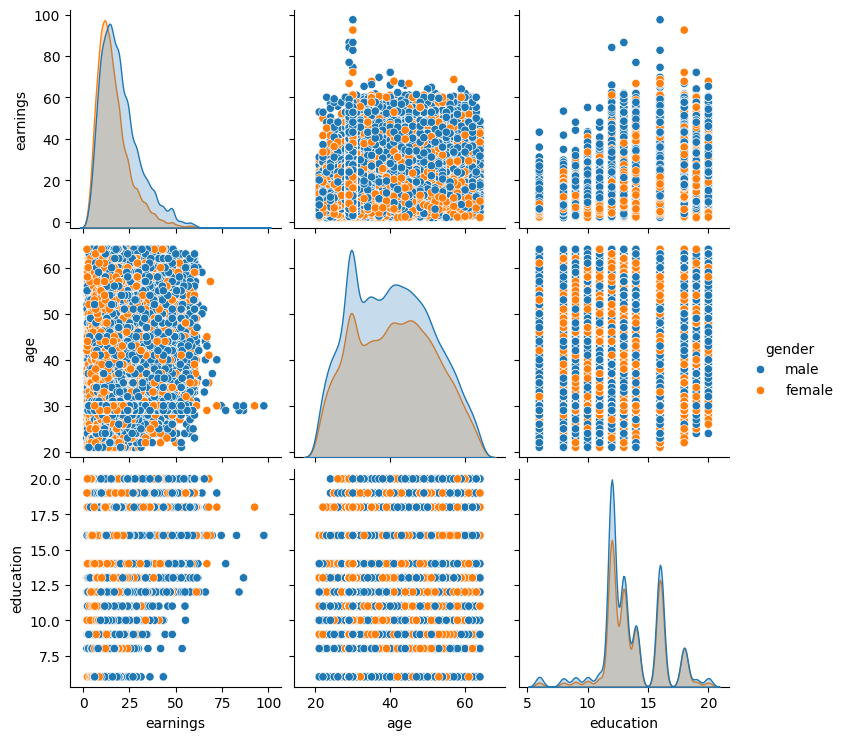

In [415]:
sns.pairplot(data=cps,hue='gender')

### 4 Data preprocessing.
#### Feature scaling
* Since I'm fitting Simple linear regression without regualization, it scaling is required because scaling does not affect predictions but will have a negative effect on coefficients of the model.

#### Feature Encoding.
* Since gender is a categorical variable, I would encode it into a numeric variable using OneHotEncoder for male = 0, and female = 1

### OneHotEncoder Configuration Explained

### encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

- **OneHotEncoder(...)**  
  Creates an encoder that converts categorical values (like `male`, `female`) into binary dummy variables (0/1).

- **handle_unknown='ignore'**  
  If a new category appears at transform time that wasn’t seen during fitting, the encoder outputs all zeros instead of raising an error.  
  *Example:* If trained on `['male', 'female']` and later sees `['nonbinary']`, it encodes as `[0]`.

- **sparse_output=False**  
  Returns a dense NumPy array instead of a memory‑efficient sparse matrix.  
  Dense arrays are easier to convert into pandas DataFrames for inspection and regression.

- **drop='first'**  
  Drops the first category in each feature to avoid perfect multicollinearity in regression models.  
  Coefficients are interpreted relative to the dropped (baseline) category.  
  *Example:* If categories are `['female', 'male']` and `drop='first'`, only `gender_male` is kept, with `female` as the baseline.


  # Notes: OneHotEncoder with More Than Two Categories

## Scenario
When you encode more than 2 categories:

Suppose you have a feature like `region` with 4 categories:
- North
- South
- East
- West

With `drop=None`, OneHotEncoder would normally create 4 dummy columns:
- region_North  
- region_South  
- region_East  
- region_West  

---

##  What happens if you drop one baseline?
- If you set `drop='first'`, OneHotEncoder automatically drops the first category (e.g., `region_North`).
- You’ll then have 3 dummy columns:
  - region_South  
  - region_East  
  - region_West  
- The dropped category (`North`) becomes the baseline.
- **Interpretation:** coefficients for South, East, West are relative to North.

---

##  Is it okay to drop any baseline?
Yes — mathematically, you can drop any one category.
- Dropping one avoids perfect multicollinearity (the dummy variable trap).
- Which one you drop doesn’t affect the model’s fit or predictions — it only changes the reference category for interpretation.
- **Example:**  
  - Drop North → coefficients are relative to North.  
  - Drop West → coefficients are relative to West.

---

##  Key Point
- Always drop **exactly one category per feature** (when using linear regression with an intercept).
- Dropping more than one wastes information.
- Dropping none causes redundancy (linear dependence).

In [416]:
# Step 1: One-hot encode
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
gender_encoded = encoder.fit_transform(cps[['gender']])

# Step 2: Create DataFrame with correct names
gender_df = pd.DataFrame(
    gender_encoded,
    columns=encoder.get_feature_names_out(['gender']),
    index=cps.index  #  preserve index alignment
)

# Step 3: Drop ORIGINAL 'gender' column and add encoded columns
cps_encoded = cps.drop(columns=['gender']).join(gender_df)

# Optional: Ensure encoded columns are int (not float due to NaN handling)
cps_encoded[gender_df.columns] = cps_encoded[gender_df.columns].astype(int)



cps_encoded.head()

,earnings,age,education,gender_male
0,20.673077,31,14,1
1,24.278847,50,12,1
2,10.149572,36,12,1
3,8.894231,33,10,0
4,6.410256,56,10,0


* Give columns proper names

In [417]:
cps_encoded.rename(columns={
    'earnings': 'Earning ($)',
    'age': 'Age (yrs)',
    'education': 'Education (yrs)',
    'gender_male': 'Male'  # clearer label: 1 = male, 0 = female
}, inplace=True)

cps_encoded.head()

,Earning ($),Age (yrs),Education (yrs),Male
0,20.673077,31,14,1
1,24.278847,50,12,1
2,10.149572,36,12,1
3,8.894231,33,10,0
4,6.410256,56,10,0


In [424]:
# Example: OLS model
import statsmodels.api as sm
X = cps_encoded[['Male', 'Age (yrs)', 'Education (yrs)']]
X = sm.add_constant(X)
y = cps_encoded['Earning ($)']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Earning ($)   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     7000.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:55:37   Log-Likelihood:            -2.3102e+05
No. Observations:               64345   AIC:                         4.621e+05
Df Residuals:                   64341   BIC:                         4.621e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -14.1375      0.236    -

### Split data into train and test portions.
* 1. Create dataframes for target and predictor variables.
* 2. Apply *train_test_split()* from *sklearn.model selection*.

In [419]:
# 'Earnings' is the  target column
X = cps_encoded.drop(columns=['Earning ($)'], axis=1)   # features
y = cps_encoded['Earning ($)']                # target

# Now split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 5. Model Fitting.

In [420]:
model = LinearRegression()
model.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 6. Model Evaluation.
* Check performance r2, rmse, mae...

In [421]:
# Generate predictions on the test set
y_pred = model.predict(X_test)

# Evaluate with R²
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

traini_score = model.score(X_train,y_train)
traini_score

test_score = model.score(X_test,y_test)
test_score

R² Score: 0.24309034772434046


0.24309034772434046

## Model Diagnostics. 

* This explains wht the model behaves that way.
### Residual Plot
- Points should scatter randomly around the red line at zero.
- Patterns (curves, waves) → suggest non‑linearity.
- Increasing spread → heteroscedasticity (variance of errors grows with predictions).
- Outliers → points far from the line.


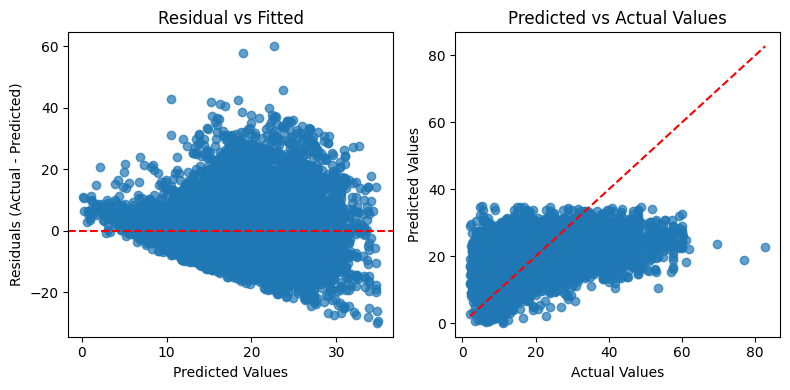

In [422]:
# Calculate residuals
residuals = y_test - y_pred

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8,4))

# Residual vs Fitted
axes[0].scatter(y_pred, residuals, alpha=0.7)
axes[0].axhline(y=0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted Values")
axes[0].set_ylabel("Residuals (Actual - Predicted)")
axes[0].set_title("Residual vs Fitted")

# Predicted vs Actual
axes[1].scatter(y_test, y_pred, alpha=0.7)
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color="red", linestyle="--")  # perfect fit line
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")
axes[1].set_title("Predicted vs Actual Values")

plt.tight_layout()
plt.show()

### Plot the model and the actual train data.
- Direct visualization is not straightforward because the relationship is in higher dimensions.
- Options:
  - **2D projections:** Plot one feature vs target, holding other features fixed (partial regression plots).
  - **3D plots:** If you have exactly two predictors, you can plot a 3D scatter (X1, X2, y) and overlay the regression plane.
  - **Residual plots:** Plot predicted vs actual values, or residuals vs predicted, to assess fit quality.
  - **Feature importance/coefficients:** Visualize how each predictor contributes to the target.

In [423]:
#

### 7. Model Validation
* Calculate y_pred and check residuals.

### 

## References

- Becker, G.S. (1964). *Human Capital: A Theoretical and Empirical Analysis with Special Reference to Education*. NBER. [Link](https://www.nber.org/books-and-chapters/human-capital-theoretical-and-empirical-analysis-special-reference-education-first-edition)

- Mincer, J. (1974). *Schooling, Experience, and Earnings*. NBER. [Link](https://www.nber.org/books-and-chapters/schooling-experience-and-earnings)

- Stock, J.H., & Watson, M.W. (2007). *Introduction to Econometrics (2nd Edition)*. Pearson/Addison Wesley. [Link](https://archive.org/details/introductiontoec0000stoc)

- U.S. Bureau of Labor Statistics. *Current Population Survey (CPS)*. [Link](https://www.bls.gov/cps/)